<a href="https://colab.research.google.com/github/janna-in-sf/DataSF-311-Cases/blob/main/DataSF_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataSF Project

Data from Data SF on 311 requests/cases to city of San Francisco. 

*    See: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6 
*   Started: January 2023
*   Status: Work in Progress
*   Janna Voss



## Imports

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

import math
import time
from datetime import datetime

## Load Input File

### Mount Drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### Read CSV

In [3]:
# set variables
file_path = '/content/drive/MyDrive/colab_files/data/'
file_name = '311_Cases.csv'
absolute_file_name = file_path + file_name

# hardcoded column names for cols to keep from input CSV file
col_names = ['CaseID', 'Opened', 'Closed', 'Updated','Status', 'Status Notes',
             'Responsible Agency', 'Category', 'Request Type', 'Request Details',
             'Address', 'Street', 'Supervisor District', 'Neighborhood', 
             'Police District','Latitude', 'Longitude', 'Source']
col_types = {'Status': 'category', 'Supervisor District':'category', 
             'Police District':'category', 'Latitude': 'float32', 
             'Longitude': 'float32','Source':'category'}
col_index_name = 'CaseID'

In [14]:
# Load the file
print('Loading file: ', absolute_file_name,'\n')

rows_to_load = 2500
csv_date_format = '%m/%d/%Y %I:%M:%S %p'

start = time.time()
print("Start Time =", datetime.now().strftime("%H:%M:%S"))

#df = pd.read_csv(absolute_file_name, usecols=col_names, dtype=col_types, 
#                 index_col= col_index_name)
df = pd.read_csv(absolute_file_name, usecols=col_names, dtype=col_types, 
                 index_col= col_index_name, nrows=rows_to_load)

# change type for dates
for date_col_name in ['Opened','Closed','Updated']:
  df[date_col_name] = pd.to_datetime(df[date_col_name],format=csv_date_format)

end = time.time()
print("End Time   =", datetime.now().strftime("%H:%M:%S"))
print('Elapsed time:',end - start, 'seconds')
print('\nLoaded file with (rows, cols) = ',df.shape,'\n')

print('Before converting col names', df.columns, '\n')
# rename columns that contain spaces
df.columns = df.columns.str.replace(' ', '_')

# chg col names to lower case
df= df.rename(columns=str.lower)
print('After convertin col names', df.columns)

Loading file:  /content/drive/MyDrive/colab_files/data/311_Cases.csv 

Start Time = 16:43:04
End Time   = 16:43:04
Elapsed time: 0.06742262840270996 seconds

Loaded file with (rows, cols) =  (2500, 17) 

Before converting col names Index(['Opened', 'Closed', 'Updated', 'Status', 'Status Notes',
       'Responsible Agency', 'Category', 'Request Type', 'Request Details',
       'Address', 'Street', 'Supervisor District', 'Neighborhood',
       'Police District', 'Latitude', 'Longitude', 'Source'],
      dtype='object') 

After convertin col names Index(['opened', 'closed', 'updated', 'status', 'status_notes',
       'responsible_agency', 'category', 'request_type', 'request_details',
       'address', 'street', 'supervisor_district', 'neighborhood',
       'police_district', 'latitude', 'longitude', 'source'],
      dtype='object')


In [15]:
df.head()

,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,source
CaseID,,,,,,,,,,,,,,,,,
6501676,2016-11-06 10:10:45,2016-11-07 09:11:12,2016-11-07 09:11:12,Closed,Case Resolved - 10-98,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,"2953 HARRISON ST, SAN FRANCISCO, CA, 94110",HARRISON ST,9,Mission,MISSION,37.750233,-122.411804,Mobile/Open311
6484030,2016-11-01 11:26:26,2016-11-01 16:59:33,2016-11-01 16:59:33,Closed,Case Resolved - Pickup completed,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,Intersection of ISADORA DUNCAN LN and TAYLOR ST,ISADORA DUNCAN LN,3,Lower Nob Hill,CENTRAL,37.787567,-122.411644,Phone
6505388,2016-11-07 11:08:09,2016-11-12 16:40:17,2016-11-12 16:40:17,Closed,Case Resolved - entire area is trashed out nee...,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Electronics,Intersection of ARELIOUS WALKER DR and REVERE AVE,ARELIOUS WALKER DR,10,Hunters Point,BAYVIEW,37.725494,-122.378494,Mobile/Open311
6504738,2016-11-07 09:41:28,2016-11-07 11:11:06,2016-11-07 11:11:06,Closed,Case Resolved - If the bridge is closed DPW ca...,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,"1366 VERMONT ST, SAN FRANCISCO, CA, 94110",VERMONT ST,10,Potrero Hill,MISSION,37.752312,-122.403488,Mobile/Open311
6507086,2016-11-07 15:40:03,2016-11-08 10:10:08,2016-11-08 10:10:08,Closed,Case Resolved - meter shop has closed this req...,DPT Meter_Bike Queue,Damaged Property,Damaged Parking_Meter,Parking_Meter,"2664 MISSION ST, SAN FRANCISCO, CA, 94110",MISSION ST,9,Mission,MISSION,37.754307,-122.418839,Phone


In [16]:
df.shape

(2500, 17)

### Verify there are no duplicated CaseID (index)

In [17]:
# check for duplicate case nbrs, which are the index
assert df.index.duplicated().sum() == 0, 'Duplicated indexes - CaseID'

### Sort by index (CaseId)

In [18]:
# if values in Index are NOT monotonically increasing, sort index
print('Index is monotnoic:',df.index.is_monotonic_increasing)
status_list = ['opened','closed','updated']
print(df[status_list].head(3))

if (not df.index.is_monotonic_increasing):
  df.sort_index(inplace=True)
  print('\n*** After sorting index, index is monotnoic:',df.index.is_monotonic_increasing)
  print(df[status_list].head(3))

Index is monotnoic: False
                     opened              closed             updated
CaseID                                                             
6501676 2016-11-06 10:10:45 2016-11-07 09:11:12 2016-11-07 09:11:12
6484030 2016-11-01 11:26:26 2016-11-01 16:59:33 2016-11-01 16:59:33
6505388 2016-11-07 11:08:09 2016-11-12 16:40:17 2016-11-12 16:40:17

*** After sorting index, index is monotnoic: True
                    opened              closed             updated
CaseID                                                            
721686 2010-08-27 20:32:34 2010-09-02 15:02:39 2010-09-02 15:02:39
730283 2010-09-10 15:40:46 2010-09-15 14:42:02 2010-09-15 14:42:02
732258 2010-09-14 04:25:57 2010-09-16 14:02:37 2010-09-16 14:02:37


## Exploratory Data Analysis

### Address Any Nulls

In [19]:
# Drop row(s) containing nulls in 5% (or fewer) rows out of the total nbr of rows
# Note: Don't drop rows with null in 'Closed' - doing so will remove all open open cases

if df.isna().sum().any():
  keep_cols = ['closed', 'updated']
  threshold = df.shape[0] * 0.05

  cols_below_threshold = df.columns[(df.isna().sum() > 0) & (df.isna().sum() <= threshold)]
  if cols_below_threshold.isin(keep_cols).any():
    cols_below_threshold = cols_below_threshold.drop(keep_cols, errors='ignore')

  if len(cols_below_threshold) > 0 :
    print('Threshold:', threshold, '\n\n*** Number of na, by column')
    print(df.isna().sum(),'\n')
    print('Nbr of columns below threshold (excluding', keep_cols,'):',len(cols_below_threshold))
    print('Names of columns below threshold:', cols_below_threshold)

    df2 = df.copy()
    df.dropna(subset=cols_below_threshold, inplace=True)
    print('\n*** Number of rows dropped due to nulls:', df2.shape[0]-df.shape[0])

    # validate 
    assert df.shape[1] == df2.shape[1], 'ERROR: Logic to drop rows for nulls inadvertently dropped columns!'
    for col in cols_below_threshold:
      assert df[col].isna().sum() == 0, f'Did not remove rows with nulls in col {col}'
    del df2, cols_below_threshold, keep_cols

Threshold: 125.0 

*** Number of na, by column
opened                   0
closed                   5
updated                  0
status                   0
status_notes             3
responsible_agency       0
category                 0
request_type             0
request_details         60
address                  0
street                 128
supervisor_district    128
neighborhood           133
police_district        136
latitude                 0
longitude                0
source                   0
dtype: int64 

Nbr of columns below threshold (excluding ['closed', 'updated'] ): 2
Names of columns below threshold: Index(['status_notes', 'request_details'], dtype='object')

*** Number of rows dropped due to nulls: 63


### Address Duplicate Rows

In [20]:
# Drop any duplicated rows, keeping the first instance
if df.duplicated().any():
  before_dropping_dups = df.shape[0]
  print('Number of duplicated rows:', len(df[df.duplicated(keep=False)]))

  df.drop_duplicates(keep='first', inplace=True)
  print('Number of rows dropped due to dups (keeping 1st occurrence)',before_dropping_dups - df.shape[0])

### View Data & Summary Stats

In [21]:
df.head()

,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,source
CaseID,,,,,,,,,,,,,,,,,
721686,2010-08-27 20:32:34,2010-09-02 15:02:39,2010-09-02 15:02:39,Closed,Case Transferred - # 372527,MUNI Work Queue,MUNI Feedback,MUNI - Services_Service_Delivery_Facilities,605_Vehicle_Maintenance_Noise,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone
730283,2010-09-10 15:40:46,2010-09-15 14:42:02,2010-09-15 14:42:02,Closed,Case Transferred - 373563,MUNI Work Queue,MUNI Feedback,MUNI - Services_Service_Delivery_Facilities,608_Station_Stop_Appearance_Maintenance,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone
732258,2010-09-14 04:25:57,2010-09-16 14:02:37,2010-09-16 14:02:37,Closed,Case Transferred - 373691,MUNI Work Queue,MUNI Feedback,MUNI - Conduct_Discourteous_Insensitive_Inappr...,303_Fare_Transfer_POP_Dispute,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone
2899186,2013-10-02 14:57:53,2015-04-15 04:05:25,2015-04-15 04:05:25,Closed,Case Transferred - Per process - cases are clo...,311 Service Request Queue - Hold,Damaged Property,Damaged Traffic_Signal,Traffic_Signal,Intersection of 3RD ST and INGERSON AVE,3RD ST,10,Bret Harte,BAYVIEW,37.720982,-122.396271,Phone
4328069,2014-12-23 10:43:18,2014-12-23 12:45:40,2014-12-23 12:45:40,Closed,Case Completed - resolved: Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Refrigerator,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Integrated Agency


In [22]:
df.tail()

,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,source
CaseID,,,,,,,,,,,,,,,,,
10401883,2019-01-24 16:26:00,2019-01-24 17:57:19,2019-01-24 17:57:19,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Boxed or Bagged Items,"2899 SAN BRUNO AVE, SAN FRANCISCO, CA, 94134",SAN BRUNO AVE,9,Portola,BAYVIEW,37.725506,-122.402557,Phone
10405876,2019-01-25 14:25:00,2019-01-25 20:24:48,2019-01-25 20:24:48,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,"501 GROVE ST, SAN FRANCISCO, CA, 94102",GROVE ST,5,Hayes Valley,NORTHERN,37.777439,-122.425117,Phone
15560868,2022-07-12 05:59:00,2022-07-12 14:14:40,2022-07-12 14:14:40,Closed,Case Resolved - Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Furniture,"139 WEBSTER ST, SAN FRANCISCO, CA, 94117",WEBSTER ST,5,Lower Haight,NORTHERN,37.771954,-122.428917,Mobile/Open311
15564300,2022-07-12 18:11:00,2022-07-14 19:34:27,2022-07-14 19:34:27,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,Missed_Route_Mechanical_Sweeping,Missed_Route_Mechanical_Sweeping,Intersection of LINCOLN WAY and LA PLAYA,LINCOLN WAY,4,Outer Sunset,TARAVAL,37.764034,-122.509399,Phone
16205667,2022-12-20 15:08:00,2022-12-20 15:23:05,2022-12-20 15:23:05,Closed,Case Resolved,DPW Ops Queue,Graffiti,Graffiti on Other_enter_additional_details_below,Other_enter_additional_details_below - Offensive,"600 CLAYTON ST, SAN FRANCISCO, CA, 94117",CLAYTON ST,5,Haight Ashbury,PARK,37.769859,-122.448471,Mobile/Open311


In [23]:
df.sample(n=3)

,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,source
CaseID,,,,,,,,,,,,,,,,,
6494517,2016-11-03 23:52:15,2016-11-04 13:15:24,2016-11-04 13:15:24,Closed,Case Resolved - SES Graffiti Crew - Paint - P...,DPW Ops Queue,Graffiti,Graffiti on Other_enter_additional_details_below,Other_enter_additional_details_below - Offensive,"1556 HOWARD ST, SAN FRANCISCO, CA, 94103",HOWARD ST,6,South of Market,SOUTHERN,37.772469,-122.416618,Mobile/Open311
6480398,2016-10-31 14:05:19,2016-11-14 11:11:47,2016-11-14 11:11:47,Closed,Case Resolved - graffiti has been removed,PUC - Water - Graffiti Queue,Graffiti,Graffiti on Fire_hydrant,Fire_hydrant - Not_Offensive,Intersection of BUSH ST and GRANT AVE,BUSH ST,3,Downtown / Union Square,CENTRAL,37.790691,-122.405594,Mobile/Open311
6476403,2016-10-30 13:51:00,2016-11-01 19:15:33,2016-11-01 19:15:33,Closed,Case Resolved - 10-98,DPW Ops Queue,Street and Sidewalk Cleaning,Medical Waste,Needles,"535 ALABAMA ST, SAN FRANCISCO, CA, 94110",ALABAMA ST,9,Mission,MISSION,37.762592,-122.412109,Mobile/Open311


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2437 entries, 721686 to 16205667
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   opened               2437 non-null   datetime64[ns]
 1   closed               2435 non-null   datetime64[ns]
 2   updated              2437 non-null   datetime64[ns]
 3   status               2437 non-null   category      
 4   status_notes         2437 non-null   object        
 5   responsible_agency   2437 non-null   object        
 6   category             2437 non-null   object        
 7   request_type         2437 non-null   object        
 8   request_details      2437 non-null   object        
 9   address              2437 non-null   object        
 10  street               2315 non-null   object        
 11  supervisor_district  2315 non-null   category      
 12  neighborhood         2310 non-null   object        
 13  police_district      230

In [25]:
# nbr unique for each col
print('Nbr unique values per column, out of total of',df.shape[0],'rows\n')
print(df.nunique(dropna=False))

Nbr unique values per column, out of total of 2437 rows

opened                 2435
closed                 2380
updated                2381
status                    2
status_notes            796
responsible_agency       85
category                 34
request_type            142
request_details         327
address                2021
street                  588
supervisor_district      13
neighborhood            110
police_district          11
latitude               2120
longitude              1963
source                    6
dtype: int64


### Consider Catagorical Features

In [27]:
# These are numbers, but not measures
# Does the number indicate a supervisor or (more likely) an area of the city?
# How does this district compare to 'Police District' or 'Neighborhood'?
# There are 13 Supervisor Districts and 11 Police Districts, (118 Neighborhoods) -
#      are the line designating these districts the same?
df.supervisor_district.value_counts()


9     388
6     368
3     319
8     235
1     218
10    208
5     203
11    112
4      97
2      89
7      73
0       5
Name: supervisor_district, dtype: int64

In [28]:
df.police_district.value_counts()
# ALLCAPS

MISSION       503
SOUTHERN      330
CENTRAL       294
RICHMOND      235
NORTHERN      218
INGLESIDE     212
BAYVIEW       183
TARAVAL       176
PARK          119
TENDERLOIN     37
Name: police_district, dtype: int64

In [29]:
df.source.value_counts()

Mobile/Open311       1267
Phone                 772
Web                   323
Integrated Agency      66
Twitter                 7
Other Department        2
Name: source, dtype: int64

In [30]:
print(df['status_notes'].sample(n=8))

CaseID
6483674                    Case Resolved - Pickup completed.
6484911    Case Resolved - PRIVATE PROPERTY;PENDING PIO I...
6489042           Case Resolved - 11/4/16 ALREADY POSTED. RC
6491858                                Case Resolved - 10/98
6478450                                        Case Resolved
6472380                                     Case Transferred
6497155      Case is a Duplicate - Duplicate case of 6497334
6489912                    Case Resolved - Pickup completed.
Name: status_notes, dtype: object


In [31]:
df.status_notes.value_counts()

Case Resolved                                                                                                                                                                             394
Case Resolved - Pickup completed.                                                                                                                                                         287
Case Transferred                                                                                                                                                                          114
Scheduled                                                                                                                                                                                  68
Case Resolved - 10-98                                                                                                                                                                      66
                                                  

In [32]:
# Should these been changed? Maybe add col for 'case_resolved'?

df_quick = df.query("status_notes.str.contains('Case Resolved').values")
df_quick.filter(['status', 'status_notes'])
#del df_quick

,status,status_notes
CaseID,,
6278946,Closed,Case Resolved - Completed.......
6471253,Closed,Case Resolved - Maximo Service Request has bee...
6471273,Closed,Case Resolved - WASTE NOT FOUND ...
6471317,Closed,Case Resolved - Customer called 311 and was pr...
6471338,Closed,Case Resolved
...,...,...
10401883,Closed,Case Resolved - Pickup completed.
10405876,Closed,Case Resolved - Pickup completed.
15560868,Closed,Case Resolved - Pickup completed.


In [33]:
# Request type: most common 'General Cleaning' & 'Bulky Items'
df['request_type'].value_counts().nlargest(n=10)


Bulky Items                                         440
General Cleaning                                    349
Encampment Reports                                  165
Human or Animal Waste                               111
Graffiti on Building_commercial                      74
Abandoned Vehicles                                   70
request_for_service                                  56
Hazardous Materials                                  48
Graffiti on Other_enter_additional_details_below     45
Individual Concerns                                  42
Name: request_type, dtype: int64

In [35]:
#earliest requests that are still open
df[df['status']=='Open'].nsmallest(n=5, columns='opened')


,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,source
CaseID,,,,,,,,,,,,,,,,,
6472767,2016-10-28 23:52:37,NaT,2016-10-28 23:52:37,Open,accepted,PUC Streetlights Queue,Streetlights,Streetlight - Other_Request_New_Streetlight,Other_Request_New_Streetlight on Metal Pole,Intersection of MARKET ST and SOUTH VAN NESS AVE,MARKET ST,6,South of Market,SOUTHERN,37.775146,-122.419258,Mobile/Open311
6497603,2016-11-04 17:00:27,NaT,2016-11-04 17:03:33,Open,accepted,DPW - Bureau of Street Use and Mapping - G,General Request - PUBLIC WORKS,customer_callback,bsm - customer_callback,Intersection of 4TH ST and KING ST,4TH ST,6,Mission Bay,SOUTHERN,37.776382,-122.394096,Phone


### Drop rows where 'Status Notes' contains 'Case is a Duplicate'

In [37]:
# df with 'Status_Notes' contains 'Case is a Duplicate'
df_quick = df.query("status_notes.str.contains('Case is a Duplicate').values")

#if len(df_quick) > 0:
if not df_quick.empty:  
  print('Found', df_quick.shape[0],'rows with "Status_Notes" containing "Case is a Duplicate"')
  before_drop = df.shape[0]

  # drop those rows
  df = df.drop(df_quick.index)

  print('Dropped', before_drop - df.shape[0], 'rows containing "Case is a Duplicate"')
  assert df.shape[0] == before_drop - df_quick.shape[0], 'Dropped unexpected number of rows'
  del df_quick

Found 58 rows with "Status_Notes" containing "Case is a Duplicate"
Dropped 58 rows containing "Case is a Duplicate"


In [38]:
df.shape

(2379, 17)

###Feature Engineering

In [39]:
# Create dataframe for open 311 cases
df_open = df[df['status']=='Open'].copy()

# don't need these cols
df_open = df_open.drop(columns=['closed','status'])
df_open.shape

(2, 15)

In [40]:
# Create dataframe for closed 311 cases
df_closed = df[df['status']=='Closed'].copy()
df_closed = df_closed.drop(columns='status')
df_closed.shape

(2377, 16)

In [41]:
# new cols...
#  calculate how long open cases have been open (days_open)
#  calculate processing_days for closed cases
#  break out year opened
#  create col for month & year combined

# for df_open (cases still open)
df_open['days_open'] = (datetime.now() - df_open['opened']).astype("timedelta64[D]").astype('int')

# for df_closed (cases that have been closed)
df_closed['opened_month_year'] = df_closed['opened'].dt.to_period('M')
df_closed['opened_year'] = df_closed['opened'].dt.year
df_closed['processing_days'] = (df_closed['closed'] - df_closed['opened']).astype("timedelta64[D]").astype('int')

# processing_days is < 1 if Closed date is earlier than Opened date, set to 1 (1 day to close)
df_closed.loc[df_closed['processing_days'] < 1, 'processing_days'] = 1

In [42]:
df_closed.filter(['opened', 'closed', 'opened_month_year', 'opened_year', 'processing_days']).sample(10)

,opened,closed,opened_month_year,opened_year,processing_days
CaseID,,,,,
6503973,2016-11-07 08:10:39,2016-11-07 14:10:42,2016-11,2016,1
6473656,2016-10-29 11:07:10,2016-10-29 12:23:02,2016-10,2016,1
6498275,2016-11-04 23:30:37,2016-11-09 14:00:03,2016-11,2016,4
6503627,2016-11-07 06:12:03,2016-11-07 10:03:02,2016-11,2016,1
6475770,2016-10-30 10:08:38,2016-11-08 15:34:24,2016-10,2016,9
6472048,2016-10-28 16:03:43,2016-11-04 09:05:53,2016-10,2016,6
6490288,2016-11-02 20:18:38,2016-11-02 22:10:11,2016-11,2016,1
6278946,2016-09-06 09:56:15,2016-10-17 19:16:08,2016-09,2016,41
6487958,2016-11-02 11:20:51,2016-11-02 13:54:04,2016-11,2016,1


In [43]:
df_closed.opened_month_year.value_counts()
# Why were so many cases opened in 2016? (And this shows only the cases that were closed)

2016-11    1682
2016-10     664
2014-12       9
2019-01       3
2022-07       2
2016-09       2
2010-09       2
2018-04       2
2010-08       1
2018-02       1
2018-07       1
2018-06       1
2017-08       1
2018-01       1
2017-12       1
2015-12       1
2015-04       1
2013-10       1
2022-12       1
Freq: M, Name: opened_month_year, dtype: int64

In [44]:
df_closed.head()

,opened,closed,updated,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,source,opened_month_year,opened_year,processing_days
CaseID,,,,,,,,,,,,,,,,,,,
721686,2010-08-27 20:32:34,2010-09-02 15:02:39,2010-09-02 15:02:39,Case Transferred - # 372527,MUNI Work Queue,MUNI Feedback,MUNI - Services_Service_Delivery_Facilities,605_Vehicle_Maintenance_Noise,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone,2010-08,2010,5
730283,2010-09-10 15:40:46,2010-09-15 14:42:02,2010-09-15 14:42:02,Case Transferred - 373563,MUNI Work Queue,MUNI Feedback,MUNI - Services_Service_Delivery_Facilities,608_Station_Stop_Appearance_Maintenance,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone,2010-09,2010,4
732258,2010-09-14 04:25:57,2010-09-16 14:02:37,2010-09-16 14:02:37,Case Transferred - 373691,MUNI Work Queue,MUNI Feedback,MUNI - Conduct_Discourteous_Insensitive_Inappr...,303_Fare_Transfer_POP_Dispute,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone,2010-09,2010,2
2899186,2013-10-02 14:57:53,2015-04-15 04:05:25,2015-04-15 04:05:25,Case Transferred - Per process - cases are clo...,311 Service Request Queue - Hold,Damaged Property,Damaged Traffic_Signal,Traffic_Signal,Intersection of 3RD ST and INGERSON AVE,3RD ST,10,Bret Harte,BAYVIEW,37.720982,-122.396271,Phone,2013-10,2013,559
4328069,2014-12-23 10:43:18,2014-12-23 12:45:40,2014-12-23 12:45:40,Case Completed - resolved: Pickup completed.,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Refrigerator,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Integrated Agency,2014-12,2014,1


In [45]:
df_closed.processing_days.value_counts()

1      1458
2       166
3       116
4        77
6        75
       ... 
739       1
760       1
689       1
627       1
592       1
Name: processing_days, Length: 61, dtype: int64

In [46]:
df_closed.opened_month_year.value_counts()

2016-11    1682
2016-10     664
2014-12       9
2019-01       3
2022-07       2
2016-09       2
2010-09       2
2018-04       2
2010-08       1
2018-02       1
2018-07       1
2018-06       1
2017-08       1
2018-01       1
2017-12       1
2015-12       1
2015-04       1
2013-10       1
2022-12       1
Freq: M, Name: opened_month_year, dtype: int64

In [47]:
df_closed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2377 entries, 721686 to 16205667
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   opened               2377 non-null   datetime64[ns]
 1   closed               2377 non-null   datetime64[ns]
 2   updated              2377 non-null   datetime64[ns]
 3   status_notes         2377 non-null   object        
 4   responsible_agency   2377 non-null   object        
 5   category             2377 non-null   object        
 6   request_type         2377 non-null   object        
 7   request_details      2377 non-null   object        
 8   address              2377 non-null   object        
 9   street               2259 non-null   object        
 10  supervisor_district  2259 non-null   category      
 11  neighborhood         2254 non-null   object        
 12  police_district      2251 non-null   category      
 13  latitude             237

In [49]:
print('rows where "Closed" date is earlier than "Opened" date...')
df_closed[ df_closed['closed'] < df_closed['opened'] ]

# often the date is same, but closed time is before opened time
# resulting in a negative value for processing_time

rows where "Closed" date is earlier than "Opened" date...


,opened,closed,updated,status_notes,responsible_agency,category,request_type,request_details,address,street,supervisor_district,neighborhood,police_district,latitude,longitude,source,opened_month_year,opened_year,processing_days
CaseID,,,,,,,,,,,,,,,,,,,


### Descriptive Analytics

In [50]:
df_open.describe(datetime_is_numeric=True)

,opened,updated,latitude,longitude,days_open
count,2,2,2.000000,2.000000,2.000000
mean,2016-11-01 08:26:32,2016-11-01 08:28:05,37.775764,-122.406677,2358.500000
min,2016-10-28 23:52:37,2016-10-28 23:52:37,37.775146,-122.419258,2355.000000
25%,2016-10-30 16:09:34.500000,2016-10-30 16:10:21,37.775455,-122.412968,2356.750000
50%,2016-11-01 08:26:32,2016-11-01 08:28:05,37.775764,-122.406677,2358.500000
75%,2016-11-03 00:43:29.500000,2016-11-03 00:45:49,37.776073,-122.400387,2360.250000
max,2016-11-04 17:00:27,2016-11-04 17:03:33,37.776382,-122.394096,2362.000000
std,NaN,NaN,0.000874,0.017792,4.949747


In [51]:
df_closed.describe(datetime_is_numeric=True)
# processing_days: note that the max is WAY higher than 75 percentile... outlier(s) 

,opened,closed,updated,latitude,longitude,opened_year,processing_days
count,2377,2377,2377,2377.000000,2377.000000,2377.000000,2377.000000
mean,2016-11-02 00:25:01.138830592,2016-11-08 20:53:46.114009088,2016-11-08 20:53:46.114009088,35.939156,-116.505493,2016.000000,6.978124
min,2010-08-27 20:32:34,2010-09-02 15:02:39,2010-09-02 15:02:39,0.000000,-122.514214,2010.000000,1.000000
25%,2016-10-31 14:10:13,2016-11-02 10:58:09,2016-11-02 10:58:09,37.750103,-122.437614,2016.000000,1.000000
50%,2016-11-02 17:01:04,2016-11-05 09:24:17,2016-11-05 09:24:17,37.769012,-122.418922,2016.000000,1.000000
75%,2016-11-05 09:57:13,2016-11-08 15:46:30,2016-11-08 15:46:30,37.780170,-122.406921,2016.000000,4.000000
max,2022-12-20 15:08:00,2022-12-20 15:23:05,2022-12-20 15:23:05,37.829617,0.000000,2022.000000,806.000000
std,NaN,NaN,NaN,8.105195,26.274872,0.364687,38.200951


##Exploratory Visualization

In [52]:
sns.set_style("whitegrid", {'axes.grid' : False})

### Visualize source

In [53]:
df.source.value_counts()

Mobile/Open311       1237
Phone                 755
Web                   313
Integrated Agency      65
Twitter                 7
Other Department        2
Name: source, dtype: int64

In [ ]:
#df.Source.value_counts().pivot().plot(kind='bar')
#plt.show()

### Histograms for time open

In [54]:
print('Quick stats on "days open", use to set range on histogram')
print(df_open.days_open.agg([min, max, np.mean, np.median, statistics.mode]))

Quick stats on "days open", use to set range on histogram
min       2355.0
max       2362.0
mean      2358.5
median    2358.5
mode      2362.0
Name: days_open, dtype: float64


In [61]:
df_open.shape

(2, 16)

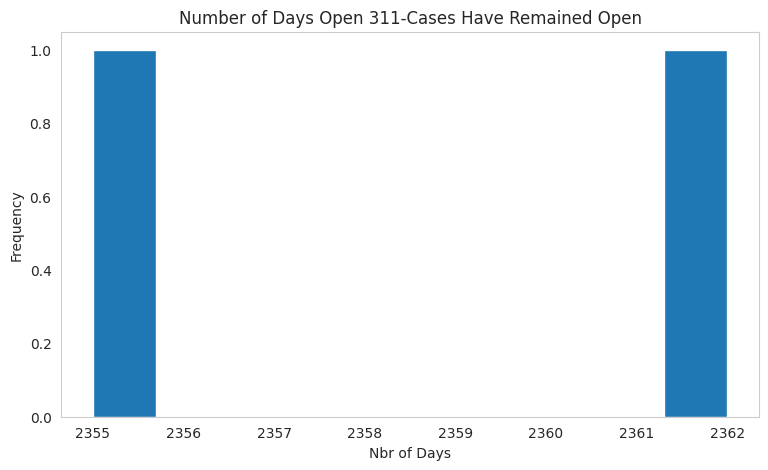

In [56]:
# hist to visaulize nbr of days open cases have remained open

# NOTE 
# Currently need to manually change the plot range to account 
# for range cases have been open, esp. in regard to the *mean*

sns.set_style("whitegrid", {'axes.grid' : False})
plt.title('Number of Days Open 311-Cases Have Remained Open')
plt.xlabel('Nbr of Days')
#df_open['days_open'].plot(kind='hist', range=[500,5100], figsize=(9,5))
df_open['days_open'].plot(kind='hist', figsize=(9,5))
plt.show()
# Note for 2500 rows, there are only 2 values for days_open

### Histograms processing time 

In [62]:
print('Quick stats on "processing days", use to set range on histogram')
print(df_closed.processing_days.agg([min, max, np.mean, np.median, statistics.mode]))

Quick stats on "processing days", use to set range on histogram
min         1.000000
max       806.000000
mean        6.978124
median      1.000000
mode        1.000000
Name: processing_days, dtype: float64


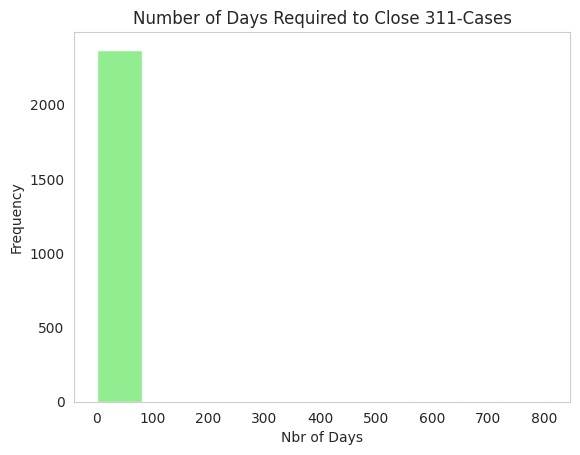

In [63]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of Days Required to Close 311-Cases')
plt.xlabel('Nbr of Days')
df_closed['processing_days'].plot(kind='hist', color='lightgreen')
plt.show()
# frequency scale is too broad to show any detail

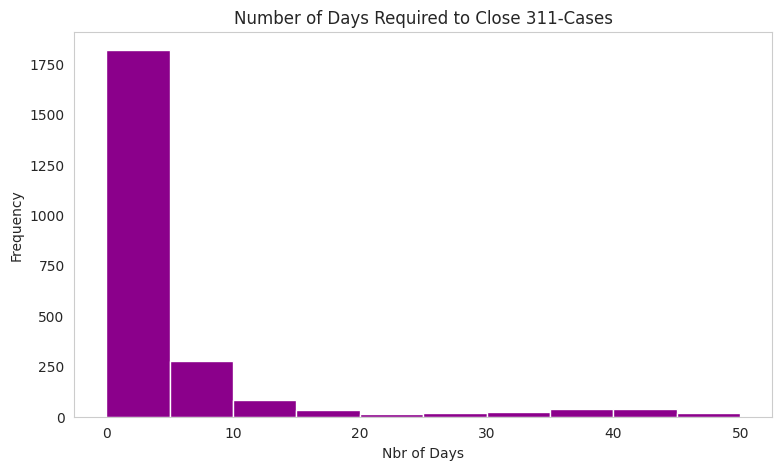

In [64]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of Days Required to Close 311-Cases')
plt.xlabel('Nbr of Days')
df_closed['processing_days'].plot(kind='hist', range=[0,50], color='DarkMagenta', figsize=(9,5))
plt.show()

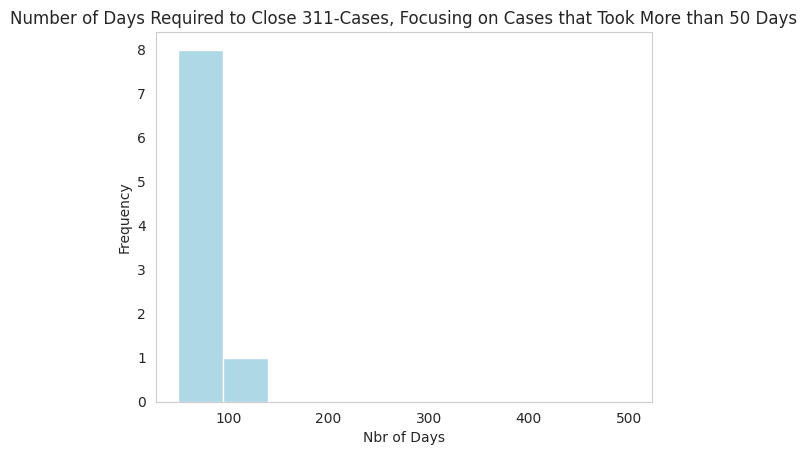

In [65]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of Days Required to Close 311-Cases, Focusing on Cases that Took More than 50 Days')
plt.xlabel('Nbr of Days')
#df_closed['processing_days'].plot(kind='hist', range=[100,900], color='LightBlue')
df_closed['processing_days'].plot(kind='hist', range=[50,500], color='LightBlue')
plt.show()

In [66]:
df_proc_less_100 = df_closed[df_closed['processing_days']<100]
df_proc_more_100 = df_closed[df_closed['processing_days']>99]

print(df_proc_less_100.shape)
print(df_proc_more_100.shape)

(2370, 19)
(7, 19)


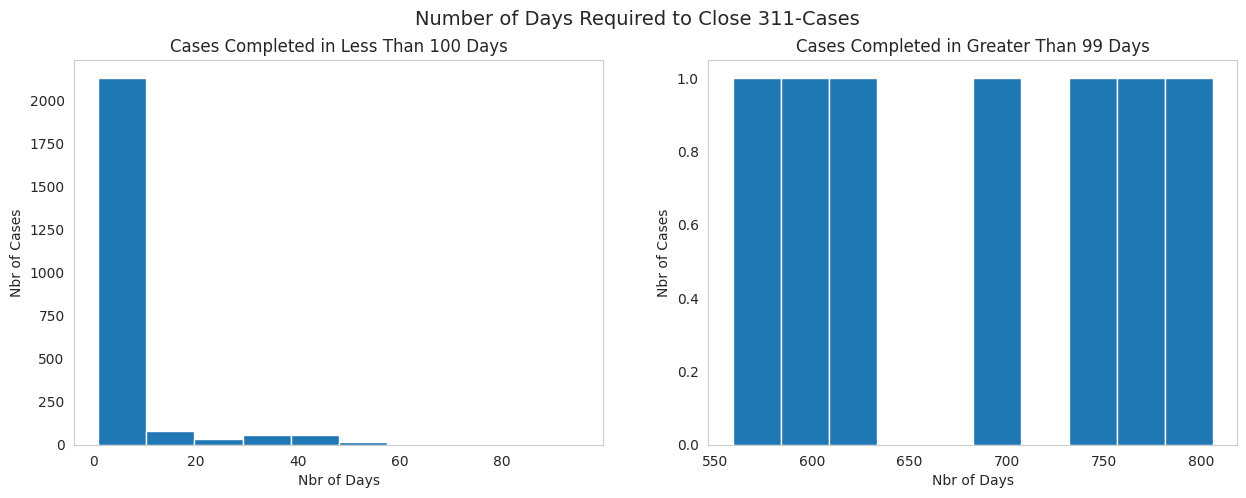

In [67]:
fig,ax =  plt.subplots(1,2, figsize=(15,5))

fig.suptitle('Number of Days Required to Close 311-Cases',fontsize=14)
ax[0].set(xlabel='Nbr of Days')
ax[1].set(xlabel='Nbr of Days')
ax[0].set(ylabel='Nbr of Cases')
ax[1].set(ylabel='Nbr of Cases')

ax[0].set_title('Cases Completed in Less Than 100 Days')
ax[1].set_title('Cases Completed in Greater Than 99 Days')

ax[0].hist(df_proc_less_100.processing_days)
ax[1].hist(df_proc_more_100.processing_days)
plt.show()

In [ ]:
# break it into 3 blocks...
df_proc_less_50 = df_closed[df_closed['processing_days']<50]
df_proc_less_100 = df_closed[df_closed['processing_days'].between(50,100)]
df_proc_more_100 = df_closed[df_closed['processing_days']>99]

print(df_proc_less_50.shape)
print(df_proc_less_100.shape)
print(df_proc_more_100.shape)

(223323, 19)
(11867, 19)
(7628, 19)


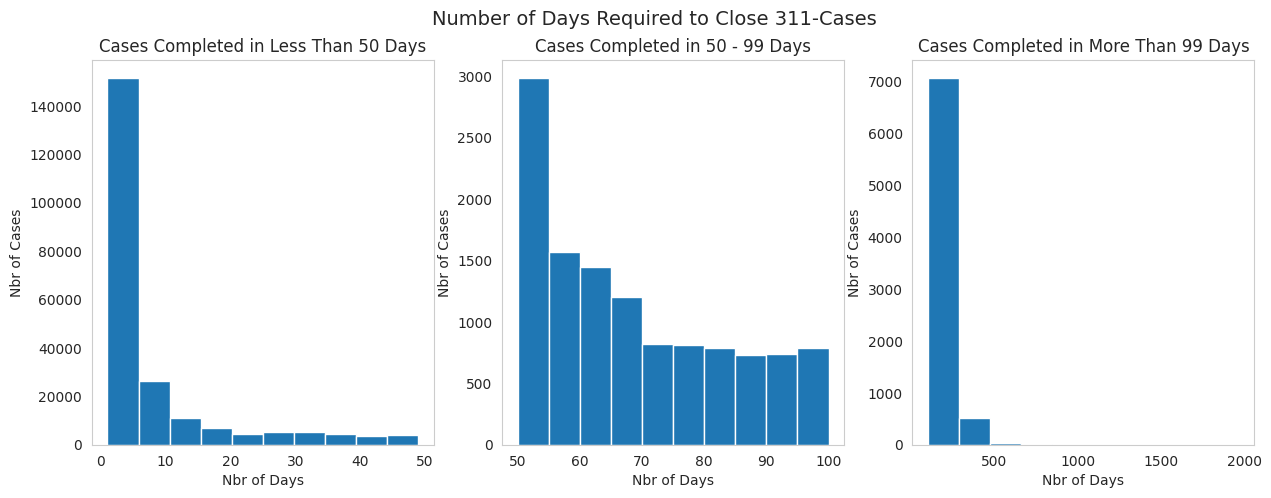

In [ ]:
fig,ax =  plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Number of Days Required to Close 311-Cases',fontsize=14)
for i in range(3):
  ax[i].set(xlabel='Nbr of Days')
  ax[i].set(ylabel='Nbr of Cases')
ax[0].set_title('Cases Completed in Less Than 50 Days')
ax[1].set_title('Cases Completed in 50 - 99 Days')
ax[2].set_title('Cases Completed in More Than 99 Days')

ax[0].hist(df_proc_less_50.processing_days)
ax[1].hist(df_proc_less_100.processing_days)
ax[2].hist(df_proc_more_100.processing_days)
plt.show()

# misleading because compares frequency scales that are completely diffefrent

In [ ]:
del df_proc_less_50, df_proc_less_100, df_proc_more_100

### Plot, over time, nbr of days required to close cases

In [69]:
print('Processing days range:',df_closed.processing_days.min(),'to',df_closed.processing_days.max())

Processing days range: 1 to 806


In [70]:
# Create df with aggregate stats for month & year (reset_index to make opened_month_year a col)
grouped_df = df_closed.groupby('opened_month_year')['processing_days'].agg([np.mean, min, max]).reset_index()

# chg col names: 'process_mean' refers to mean nbr of days required to close a 311-case
grouped_df.rename(columns={'mean': 'closing_days_mean', 'min': 'closing_days_min', 'max':'closing_days_max'},inplace=True)
grouped_df.head()

,opened_month_year,closing_days_mean,closing_days_min,closing_days_max
0,2010-08,5.000000,5,5
1,2010-09,3.000000,2,4
2,2013-10,559.000000,559,559
3,2014-12,2.333333,1,7
4,2015-04,1.000000,1,1


In [71]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   opened_month_year  19 non-null     period[M]
 1   closing_days_mean  19 non-null     float64  
 2   closing_days_min   19 non-null     int64    
 3   closing_days_max   19 non-null     int64    
dtypes: float64(1), int64(2), period[M](1)
memory usage: 736.0 bytes


<ipython-input-72-9a389c6ba49d>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels, rotation='vertical')


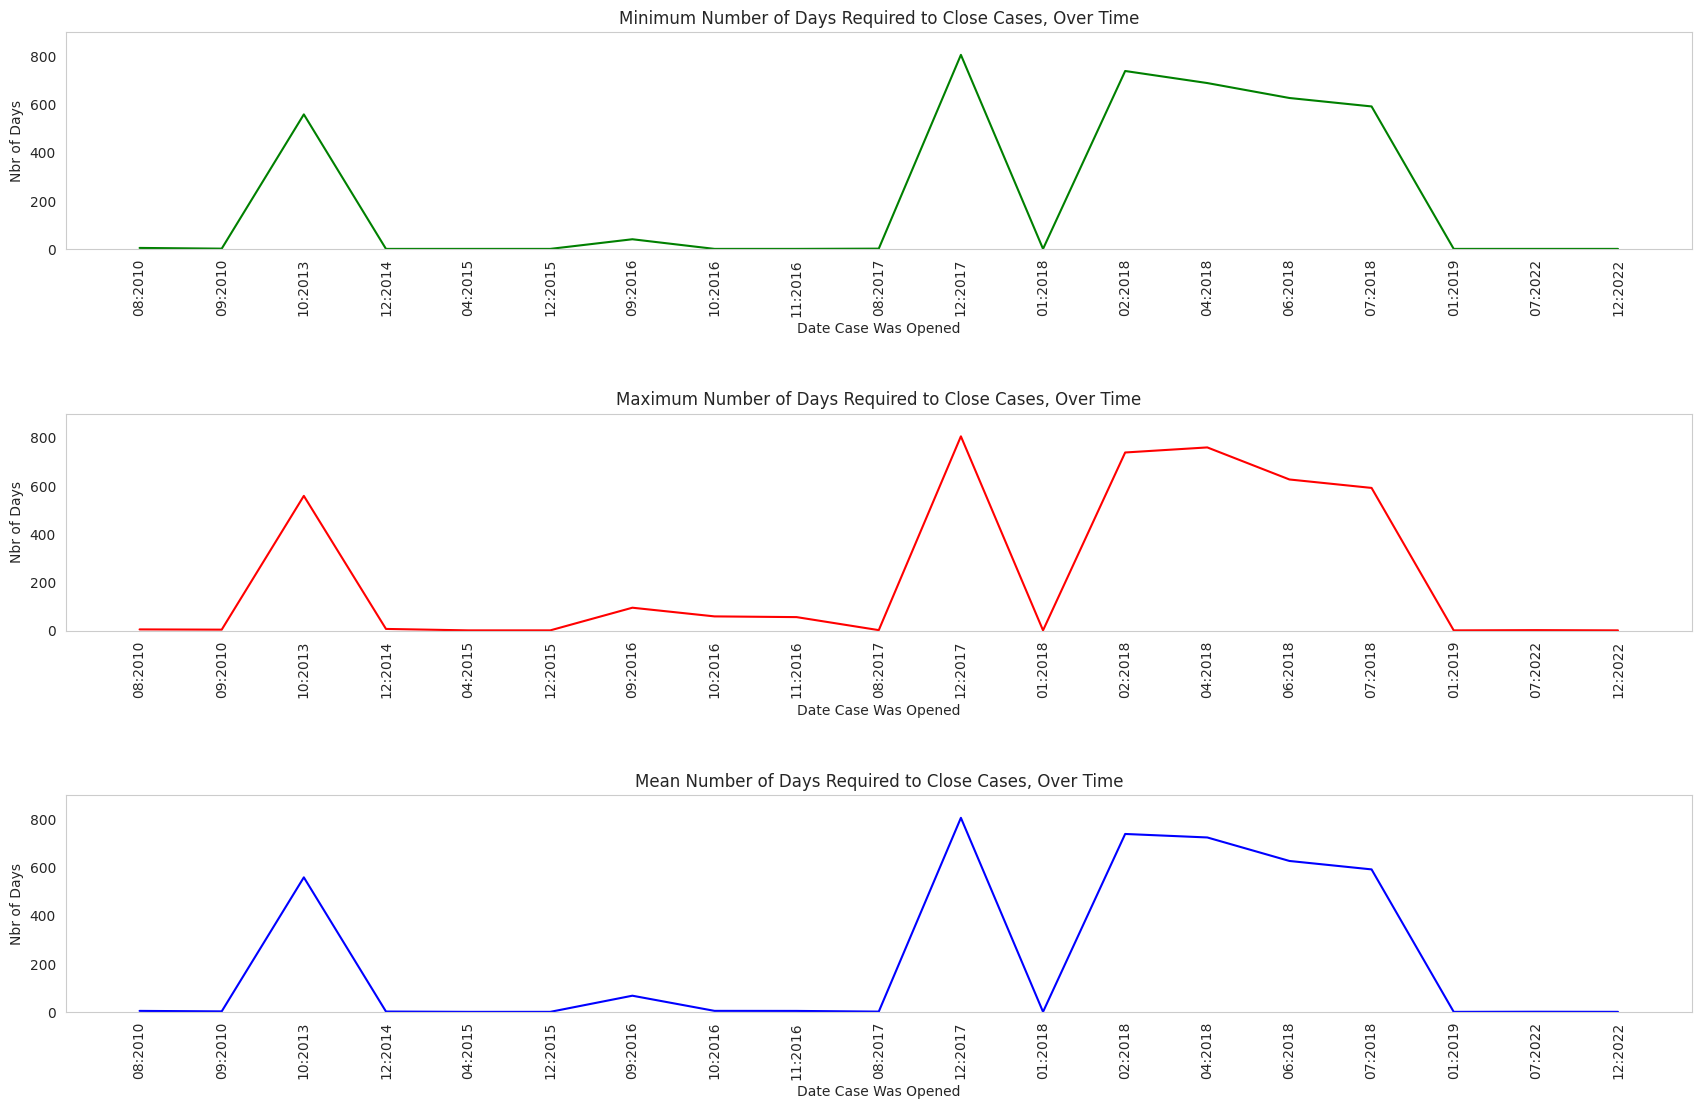

In [72]:
# Visualize nbr of days it took to close cases, over time

# ISSUE [TODO]

# What was I trying to do here???

# when more recs were read time frame expaned; now x-axis labels are too close together
# could this be switched to the year, rather than the month?
# to do that, would need to create new col for year opened, then groupby that col

labels = grouped_df.opened_month_year.dt.strftime('%m:%Y').astype(str)
x = grouped_df.closing_days_max.max()
x_max = int(math.ceil(x / 100.0)) * 100

fig, ax = plt.subplots(3,1, figsize=(18,12))
for i in range(3):
  ax[i].set(ylabel='Nbr of Days')
  ax[i].set_xticklabels(labels, rotation='vertical')
  ax[i].set(xlabel='Date Case Was Opened')
  ax[i].set_ylim([0, x_max]) # makes y scale same on all 3

ax[0].set_title('Minimum Number of Days Required to Close Cases, Over Time')
ax[1].set_title('Maximum Number of Days Required to Close Cases, Over Time')
ax[2].set_title('Mean Number of Days Required to Close Cases, Over Time')
fig.tight_layout(pad=4.0)
'''
annotate start of pandemic?
ax.annotate('pixel offset from axes fraction',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
'''
ax[0].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_min, color='g')
ax[1].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_max, color='r')
ax[2].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_mean, color='b')
plt.show()

In [73]:
# Create df with aggregate stats for month & year (reset_index to make opened_month_year a col)
year_df = df_closed.groupby('opened_year')['processing_days'].agg([np.mean, min, max]).reset_index()

# chg col names: 'process_mean' refers to mean nbr of days required to close a 311-case
year_df.rename(columns={'mean': 'closing_days_mean', 'min': 'closing_days_min', 'max':'closing_days_max'},inplace=True)
year_df.head()

,opened_year,closing_days_mean,closing_days_min,closing_days_max
0,2010,3.666667,2,5
1,2013,559.000000,559,559
2,2014,2.333333,1,7
3,2015,1.000000,1,1
4,2016,5.013203,1,95


In [74]:
del grouped_df

<ipython-input-75-2ba42fe16abd>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels)


AttributeError: ignored

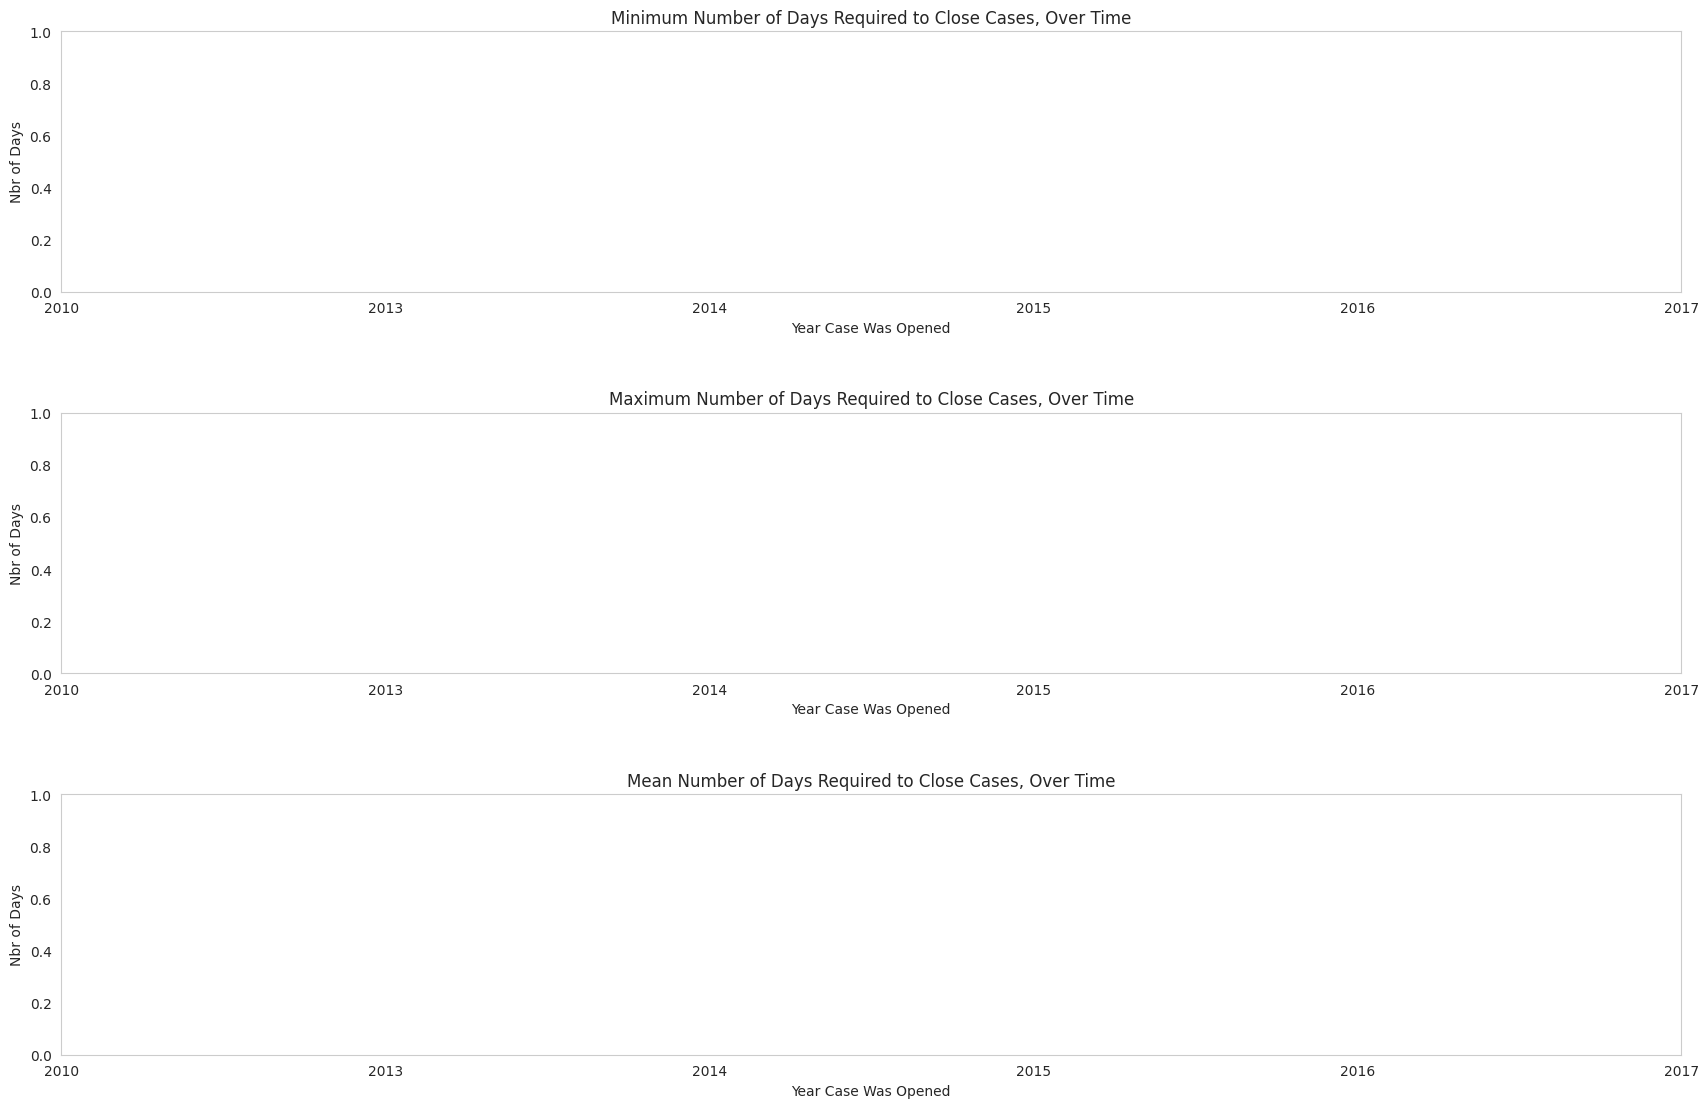

In [75]:
# same visualization, but at yearly intervals
# NOTE that the y-axis scales are NOT the same

#TODO change this to match the current way I populate opened_year

#labels = year_df.opened_year.dt.strftime('%Y').astype(str)
labels = year_df.opened_year.astype(str)

x = year_df.closing_days_max.max()
x_max = int(math.ceil(x / 100.0)) * 100

fig, ax = plt.subplots(3,1, figsize=(18,12))
for i in range(3):
  ax[i].set(ylabel='Nbr of Days')
  ax[i].set_xticklabels(labels)
  ax[i].set(xlabel='Year Case Was Opened')
#  ax[i].set_ylim([0, x_max]) # makes y scale same on all 3

ax[0].set_title('Minimum Number of Days Required to Close Cases, Over Time')
ax[1].set_title('Maximum Number of Days Required to Close Cases, Over Time')
ax[2].set_title('Mean Number of Days Required to Close Cases, Over Time')
fig.tight_layout(pad=4.0)

ax[0].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_min, color='lightgreen')
ax[1].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_max, color='plum')
ax[2].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_mean, color='lightblue')
plt.show()

### Changes over time: has the source changed over time?

### Plot closed cases 
  as a Series by: 

*   Responsible Agency
*   Category
*   Request Type
*   Supervisor District
*   Neighborhood
*   Police Disctrict




In [ ]:
# plot CLOSED cases (as a Series) by: Responsible Agency, Category, 
#  Request Type, Supervisor District, Neighborhood, Police District
# 'ranking relationship' so using horizontal bar graphs
# for Supervisor District, maybe join to diff table to get supervisor name (based on date)?

elements = ['Responsible Agency','Category', 'Request Type',
            'Supervisor District', 'Neighborhood', 'Police District']

for el in elements:
  plt.title('Most Common '+ el+' for Closed 311-Cases')
  plt.xlabel('Count')
  df_closed[el].value_counts().nlargest(n=8).sort_values().plot(kind='barh',color='g')
  plt.show()


### Plot open cases 
 as a Series by: 

*   Responsible Agency
*   Category
*   Request Type
*   Supervisor District
*   Neighborhood
*   Police Disctrict

In [ ]:
#  Supervisor District (could join to a diff table to get supervisor name)
# 'ranking relationship' so using horizontal bar graphs

# When considering 'open' cases, focus on cases that have remained open for a lengthy period
# (If a case opened yesterday is still open, that doesn't indicate an issue)

# only consider cases open for at least a year...
df_open_long = df_open[df_open['time_open'].astype('timedelta64[D]') > 365]

for e in elements:
  plt.title('Most Common '+ e+' for Open 311-Cases')
  plt.xlabel('Count')
  df_open_long[e].value_counts().nlargest(n=8).sort_values().plot(kind='barh', color='r')
  plt.show()

## **Question**: Are the most common Closed case types the same as the most common Open case types? Should I be looking at percentages instead? Relative to total number of cases?

## Correlation between [something?] and 'closure rate'
### must define 'closure rate'